In [3]:
import os
from os.path import join as opj

import numpy as np
from omegaconf import OmegaConf
from copy import deepcopy
import torch
from datetime import datetime
from matplotlib import pyplot as plt

from mcuts_main import MCUTS
from utils.gumbel_softmax import gumbel_softmax
from utils.misc import reproduc, plot_causal_matrix, plot_causal_matrix_in_training, calc_and_log_metrics
from utils.logger import MyLogger

from data.simu_data import simulate_var, simulate_random_var, simulate_var_from_links, load_netsim_data, load_springs_data, load_dream_data, simulate_lorenz_96
from data.air_quality import AirQuality
from data.pd_dataset import PandasDataset
from data.torch_dataset import TorchDataset

In [4]:
opt = OmegaConf.load("opt/lorenz_example.yaml")
device = "cuda"

reproduc(**opt.reproduc)
timestamp = datetime.now().strftime("_%Y_%m%d_%H%M%S_%f")
opt.task_name += timestamp
proj_path = opj(opt.dir_name, opt.task_name)
log = MyLogger(log_dir=proj_path, **opt.log)
log.log_opt(opt)

In [5]:
opt_data = opt.data
if opt_data.pre_sample == "point_missing":
    p_fault, p_noise = 0., float(opt_data.missing_prob)
    max_seq, min_seq = 0, 0
elif opt_data.pre_sample == "block_missing":
    p_fault, p_noise = float(opt_data.missing_prob), 0.1
    max_seq, min_seq = 48, 12
else:
    raise NotImplementedError

if not hasattr(opt_data, "dist_path"):
    opt_data.dist_path = None
if not hasattr(opt_data, "reduce"):
    opt_data.reduce = "1P"
if not hasattr(opt_data, "scale"):
    opt_data.scale = False

if "pm25" in opt_data.name:
    if "part" in opt_data.name:
        dataset = AirQuality(path=opt_data.data_path, small=True, reduce=opt_data.reduce)
    elif "all" in opt_data.name:
        dataset = AirQuality(path=opt_data.data_path, small=False, reduce=opt_data.reduce)
    else:
        raise NotImplementedError
    dataset.generate_mask(p_fault, p_noise, max_seq, min_seq)
elif any(name in opt_data.name for name in ["traffic", "electricity", "bay", "la"]):
    dataset = PandasDataset(opt_data.name, opt_data.data_path, opt_data.dist_path, opt_data.reduce, opt_data.scale)
    dataset.load()
    dataset.generate_mask(p_fault, p_noise, max_seq, min_seq)
else:
    if opt_data.name == "uniform_var":
        data, beta, true_cm = simulate_var(**opt_data.param)
    elif opt_data.name == "random_var":
        data, true_cm = simulate_random_var(**opt_data.param)
    elif opt_data.name == "var":
        data, true_cm = simulate_var_from_links(**opt_data.param)
    elif opt_data.name == "lorenz96":
        data, true_cm = simulate_lorenz_96(**opt_data.param)
    elif opt_data.name == "netsim":
        data, true_cm = load_netsim_data(**opt_data.param)
    elif opt_data.name == "dream":
        data, true_cm = load_dream_data(**opt_data.param)
    elif opt_data.name == "spring":
        data, true_cm = load_springs_data(**opt_data.param)
    else:
        raise NotImplementedError
    
    dataset = PandasDataset(opt_data.name)
    dataset.load_data(data, true_cm)
    dataset.generate_mask(p_fault, p_noise, max_seq, min_seq)

original_data = dataset.df.values
mask = dataset.training_mask
print("Data shape: ", original_data.shape)
print(f"Generated random missing with missing_prob: {1-np.mean(mask):.4f}")

Data shape:  (5000, 128)
Generated random missing with missing_prob: 0.6001


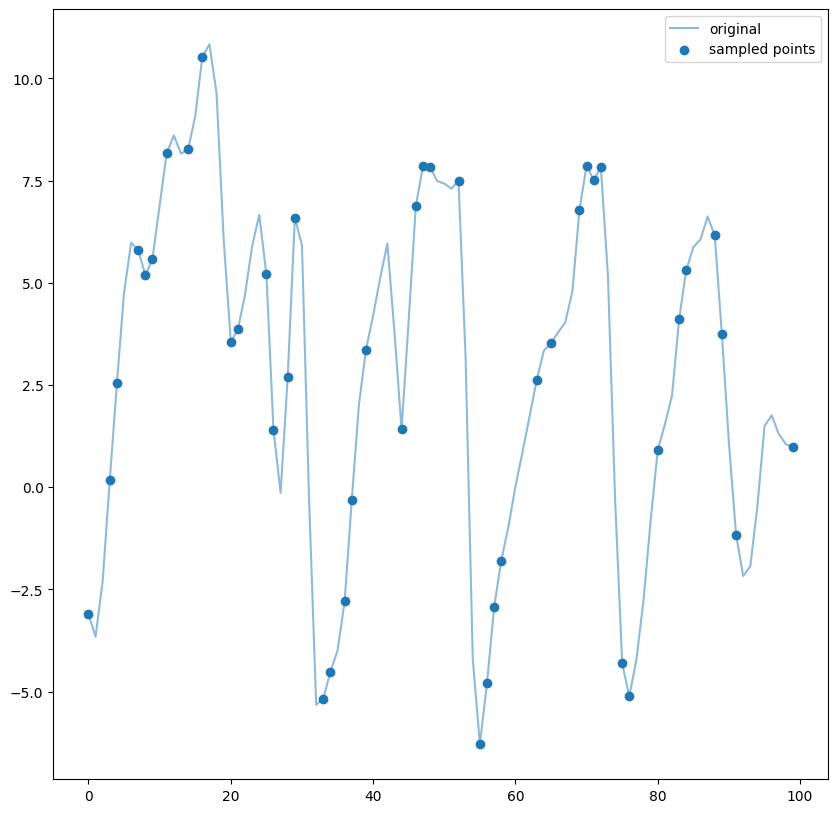

In [4]:
fig = plt.figure(figsize=[10,10])
plt.plot(np.arange(0, 100, 1), data[:100,1], label="original", alpha=0.5)
plt.scatter(np.argwhere(mask[:100,1]), data[np.argwhere(mask[:100,1]),1], label="sampled points")
plt.legend()
plt.show()

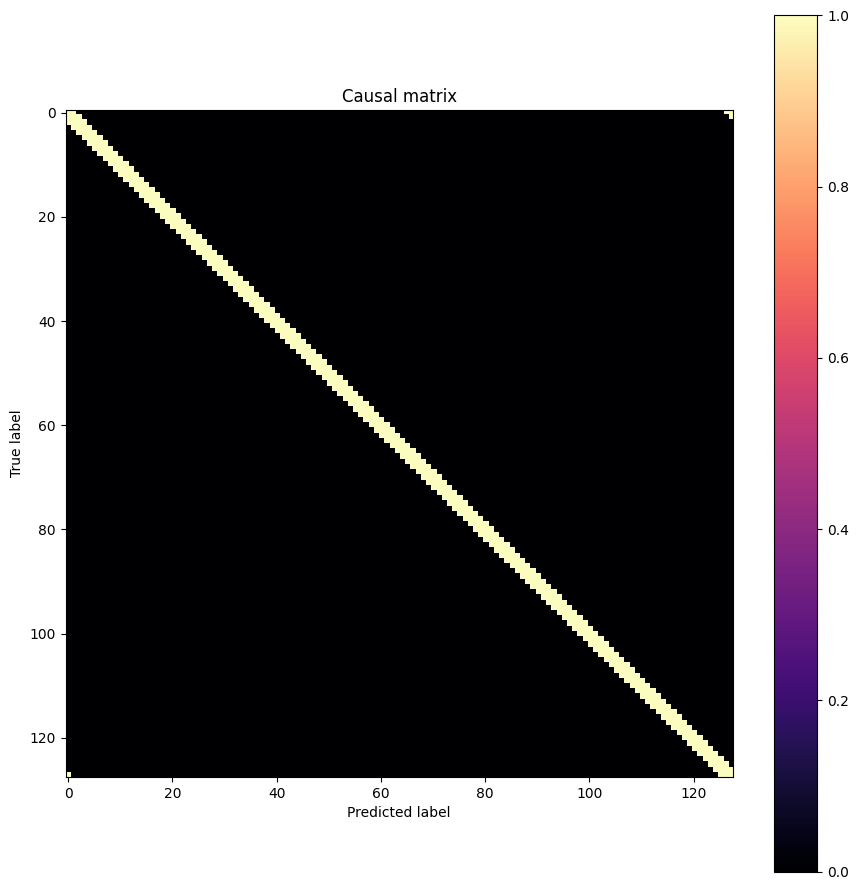

In [5]:
sub_cg = plot_causal_matrix(true_cm, figsize=[9, 9], vmin=0, vmax=1)
plt.show()

In [6]:
mcuts = MCUTS(opt.multi_cad, log, device=device)
mcuts.run(dataset)

  0%|          | 0/50 [00:00<?, ?it/s]/ssd/0/lll/mcuts/model/mcuts.py:140: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorCompare.cpp:333.)
  x_hat = torch.where(m_now, x_now, x_hat1)
 40%|████      | 20/50 [05:57<07:50, 15.70s/it, Validation loss=0.38]   /home/lll/anaconda3/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_sche

 AUC: 0.9627


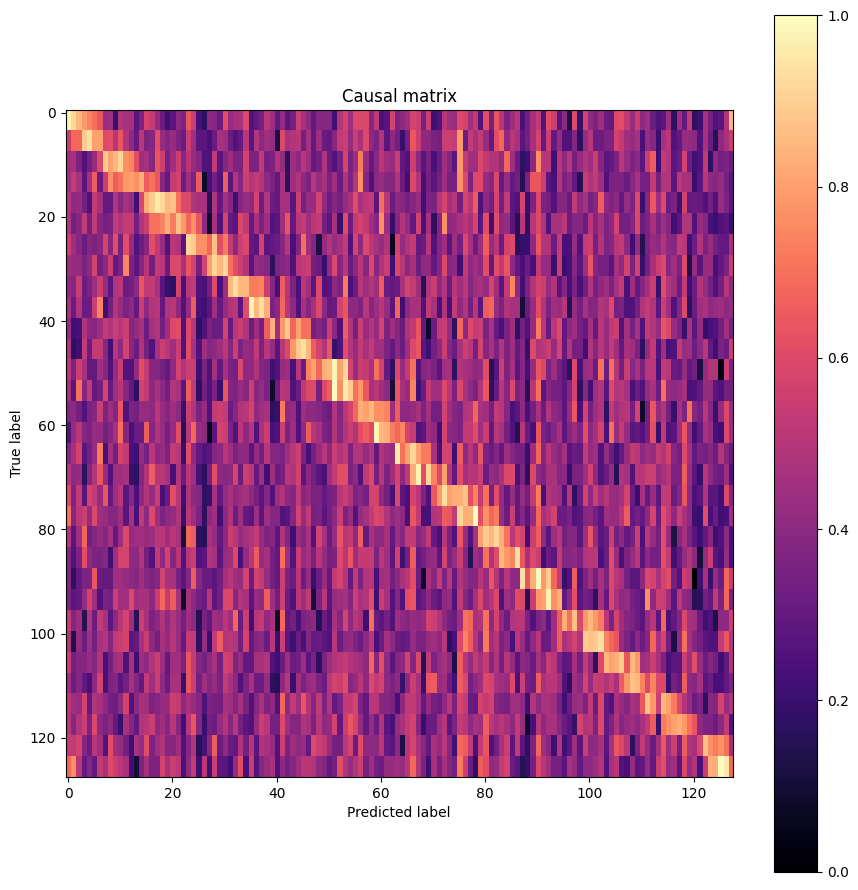

In [7]:
fwd_graph, bwd_graph, ind_graph = mcuts.get_graph()
fwd_mat = fwd_graph.detach().cpu().numpy()[:,:,None] if fwd_graph is not None else None
if np.max(fwd_mat) - np.min(fwd_mat) > 0.01:
    fwd_mat = (fwd_mat - np.min(fwd_mat)) / (np.max(fwd_mat) - np.min(fwd_mat))
sub_cg = plot_causal_matrix(fwd_mat, figsize=[9, 9], vmin=0, vmax=1)
plt.show()